E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [303]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
g = torch.Generator(device='cpu').manual_seed(2147483647)

In [304]:
SEED = 42

CONTEXT_LEN = 3

VOCAB_SIZE = 27 # 26 letters + 1 for padding
EMBED_DIMS = 10
HIDDEN_DIMS = 200

BATCH_SIZE  = 128
EPOCHS  =  1000
LEARNING_RATE = 0.001

In [305]:
words = open('names.txt').read().splitlines()

In [306]:
stoi = {s:i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [307]:
def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * CONTEXT_LEN
        chrs = list(w) + ['.']
        for c in chrs:
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, ytr = build_dataset(words[:n1])
Xv, yv = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])
# Train dataset is used to train the parameters, val is used to tune hyperparameters, and test is used to evaluate the final model.

In [308]:
assert Xtr.shape[1] == CONTEXT_LEN # N × CONTEXT_LEN
samples = Xtr.shape[0]
assert ytr.shape == (samples,)

$$ y_\text{logits} = Wx_\text{cat} + b + U\tanh(Hx_\text{cat} + d) $$
where $ x_\text{cat} $ is `C[X].view(xlen, -1)`

In [309]:
# Initialise/reset parameters

catfeatures = CONTEXT_LEN*EMBED_DIMS # In the paper: (n-1)*m, where n-1 is the context length

C = torch.randn((VOCAB_SIZE, EMBED_DIMS),             generator=g)
# C[5] ≡ F.one_hot(torch.tensor(5), num_classes=27).float() @ C. Former is faster.

H = torch.randn((HIDDEN_DIMS, catfeatures),           generator=g) * 0.1
d = torch.randn((HIDDEN_DIMS, 1),                     generator=g) * 0.01 # not 0 ∵ tanh neuron

U = torch.randn((VOCAB_SIZE, HIDDEN_DIMS),            generator=g) * 0.01
W = torch.randn((VOCAB_SIZE, catfeatures),            generator=g) * 0.01
b = torch.zeros((VOCAB_SIZE, 1))

bngain = torch.ones((HIDDEN_DIMS, 1))
bnbias = torch.zeros((HIDDEN_DIMS, 1))

params = [C, H, d, U, W, b, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [310]:
sum(p.numel() for p in params) # Total number of parameters

13107

In [311]:
print(catfeatures)

30


In [ ]:
def return_logits(Xb):
    samples = Xb.shape[0]
    cat = C[Xb].view(Xb.shape[0], -1).t()
    assert cat.shape == (catfeatures, samples)
    h_preact = H @ cat #+ d  # Hidden layer preactivations
    assert h_preact.shape == (HIDDEN_DIMS, samples)

    # Batch normalisation
    h_normalised = bngain * ((h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True)) + bnbias
    assert h_normalised.shape == (HIDDEN_DIMS, samples)
    
    logits = W @ cat + b + U @ torch.tanh(h_normalised)
    assert logits.shape == (VOCAB_SIZE, samples)
    return logits.t()  # Return shape: N × VOCAB_SIZE

In [313]:
# Train
lossi = []
stepi = []

In [314]:
deci_epoch = EPOCHS // 10
for epoch in range(EPOCHS):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]
    
    # Forward pass
    logits = return_logits(Xb)
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None # Set gradients to zero before backward pass
    loss.backward() # Populate those gradients

    # Update parameters
    with torch.no_grad():
        lr = 0.1 if epoch < EPOCHS/2 else 0.01
        for p in params:
            p.data -= lr * p.grad
    
    # Track stats
    if epoch % deci_epoch == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {loss.item()}')
    lossi.append(loss.item())
    stepi.append(epoch * (Xtr.shape[0] // BATCH_SIZE) + ix[0].item() // BATCH_SIZE)

Epoch 0/1000, Loss: 3.2874484062194824
Epoch 100/1000, Loss: 2.59639310836792
Epoch 200/1000, Loss: 2.562225341796875
Epoch 300/1000, Loss: 2.419325828552246
Epoch 400/1000, Loss: 2.507263422012329
Epoch 500/1000, Loss: 2.462912082672119
Epoch 600/1000, Loss: 2.43609619140625
Epoch 700/1000, Loss: 2.328589677810669
Epoch 800/1000, Loss: 2.264427661895752
Epoch 900/1000, Loss: 2.505157470703125


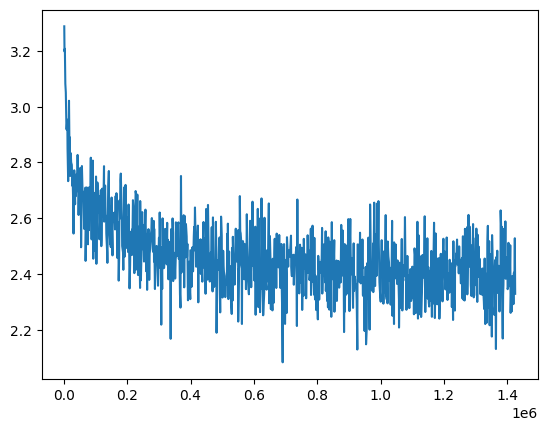

In [ ]:
plt.plot(stepi, lossi)

In [316]:
@torch.no_grad()
def get_loss(X, y):
    logits = return_logits(Xb)
    return F.cross_entropy(logits, yb)

# Evaluate on validation and test sets
val_loss = get_loss(Xv, yv)
test_loss = get_loss(Xte, yte)
print(f'Validation Loss: {val_loss}, Test Loss: {test_loss}')

Validation Loss: 2.319469690322876, Test Loss: 2.319469690322876


In [317]:
# F.cross_entropy(logits, yb) is the same as:
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -probs[torch.arange(BATCH_SIZE), yb].log().mean()
# Both will give the same result, but F.cross_entropy is more numerically stable and faster obv

In [318]:
# Generate names
NUM_NAMES = 10
MAX_LENGTH = 20

names = []

for name in range(NUM_NAMES):
    context = [0] * CONTEXT_LEN  # Start with the context of all dots
    name = []
    
    for _ in range(MAX_LENGTH):
        logits = return_logits(torch.tensor([context], dtype=torch.long))

        probs = F.softmax(logits, dim=-1).squeeze(1)

        next_char_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_char_idx == 0: break # Stop if we hit the end character (dot)
        
        name.append(itos[next_char_idx])
        context = context[1:] + [next_char_idx]  # Update context
    
    names.append(''.join(name))

print(names)

['hepvnwauleze', 'yeclye', 'assnrckyvarande', 'maylisanden', 'jleena', 'jina', 'osama', 'jalni', 'ta', 'ashaddy']
